In [1]:
!pip install gymnasium
!pip install gymnasium[box2d]
import gymnasium as gym

env = gym.make("LunarLander-v3", render_mode="rgb_array")
obs, info = env.reset()

for _ in range(10):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()

print("LunarLander OK")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.6 MB/s eta 0:00:00
LunarLander OK


In [30]:
from gymnasium.wrappers import RecordVideo

env = RecordVideo(
    gym.make("LunarLander-v3", render_mode="rgb_array"),
    video_folder="videos1",
    episode_trigger=lambda x: True
)

obs, info = env.reset()
while True:
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break

env.close()


In [3]:
import os
os.listdir("videos")


['rl-video-episode-0.mp4']

In [4]:
import gymnasium as gym

env = gym.make("LunarLander-v3")

obs, info = env.reset()

print("Observation:", obs)
print("Observation shape:", obs.shape)
print("Observation dtype:", obs.dtype)

print("Action space:", env.action_space)
print("Observation space:", env.observation_space)


Observation: [-9.6130371e-04  1.4197023e+00 -9.7382605e-02  3.9031947e-01
  1.1206752e-03  2.2058608e-02  0.0000000e+00  0.0000000e+00]
Observation shape: (8,)
Observation dtype: float32
Action space: Discrete(4)
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


**Random Agent Baseline**


*  You now have a performance baseline


*  DQN must beat this convincingly

In [5]:
def run_random_agent(env, episode=5):
  rewards=[]
  for ev in range(episode):
    obs,info=env.reset()
    total_reward=0
    while True:
      action =env.action_space.sample()
      obs, reward, terminated, truncated, info =env.step(action)
      total_reward+=reward

      if terminated or truncated:
        break;

    rewards.append(total_reward)
    print(f"Episode{ev+1}: reward={total_reward}")

  return rewards

Reward components (per step):

+10 per leg   → touching ground

+100 landing  → safe touchdown

-100 crash    → nose/any part hits ground

-0.1 distance → from landing pad   

-0.001^3 * |v|^2  → velocity penalty


In [6]:
env=gym.make("LunarLander-v3")
run_random_agent(env,episode=5)
env.close()


Episode1: reward=-392.8221697582727
Episode2: reward=-453.03510188002133
Episode3: reward=-147.883264033793
Episode4: reward=-79.64588098641296
Episode5: reward=-9.361183222319895


**Replay Buffer**


*   Storing experiences

*   Sampling them randomly






In [7]:
from collections import deque
import random
import numpy as np

class replayBuffer:

  def __init__(self, capacity):
    self.buffer=deque(maxlen=capacity)

  def push(self, state, action ,reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size):
    batch= random.sample(self.buffer, batch_size)
    states, actions, rewards, next_states, dones= zip(*batch)
    return(
        np.array(states),
        np.array(actions),
        np.array(rewards),
        np.array(next_states),
        np.array(dones)
    )

  def __len__(self):
    return len(self.buffer)

**Buffer Testing**

In [8]:
buffer =replayBuffer(capacity=1000)
env= gym.make("LunarLander-v3")
obs, info=env.reset()

for _ in range(50):
  action= env.action_space.sample()
  next_obs, reward, terminated, truncated, info= env.step(action)
  done= terminated or truncated

  buffer.push(obs, action, reward, next_obs,done)
  obs= next_obs

  if done:
    obs, info =env.reset()
print("Buffer Size: ",len(buffer))
sample=buffer.sample(8)
for items in sample:
  print(items.shape)


Buffer Size:  50
(8, 8)
(8,)
(8,)
(8, 8)
(8,)


**Q-Network**


*   This is the main intelligence everything else just supports this

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
  def __init__(self, state_dim, action_dim):
    super(QNetwork, self).__init__()
    self.fc1=nn.Linear(state_dim, 128)
    self.fc2=nn.Linear(128,128)
    self.fc3=nn.Linear(128, action_dim)

  def forward(self,x):
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    return self.fc3(x)

# fc1

Learns basic physics relationships

Position ↔ velocity ↔ angle

# fc2

Combines those into higher-level control features

“Am I falling too fast?”

“Am I tilted while descending?”

# fc3

Outputs Q-values, not probabilities



In [10]:
#Instantiating the Network
state_dim=8
action_dim=4

q_net=QNetwork(state_dim, action_dim)

#USing dummy input to test
dummy_state = torch.zeros((1, state_dim))
q_values = q_net(dummy_state)

print(q_values)
print("Shape:", q_values.shape)

tensor([[-0.0260, -0.0197, -0.0207, -0.0517]], grad_fn=<AddmmBackward0>)
Shape: torch.Size([1, 4])


In [11]:
# Device Handling
#This automatically puts QNetwork on GPU (if available) or CPU (if no GPU). Makes your DQN run 10-100x faster on GPU
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_net=q_net.to(device)

**ε-Greedy Action Selection (Policy Logic)**

In [12]:
def select_action(state, q_network, epsilon, action_dim, device):
    if random.random() < epsilon:
        # Exploration
        return random.randrange(action_dim)
    else:
        # Exploitation
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_network(state)
        return torch.argmax(q_values, dim=1).item()

**Testing ε-Greedy Behavior**

In [13]:
epsilon = 1.0
epsilon_start = 1.0  # Starting epsilon value
epsilon_end = 0.01   # Minimum epsilon value
epsilon_decay = 0.995 # Decay rate for epsilon
env = gym.make("LunarLander-v3")
state, _ = env.reset()

actions = [select_action(state, q_net, epsilon, 4, device) for _ in range(20)]
print(actions)
epsilon = 0.0
actions = [select_action(state, q_net, epsilon, 4, device) for _ in range(20)]
print(actions)
#ε deccay logic
epsilon = max(epsilon_end, epsilon * epsilon_decay)

[2, 2, 1, 2, 2, 1, 1, 2, 0, 0, 2, 2, 0, 3, 3, 2, 0, 2, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**Target Network**

If:

The same network computes Q(s,a) and Q(s',a')

And that network is being updated every step

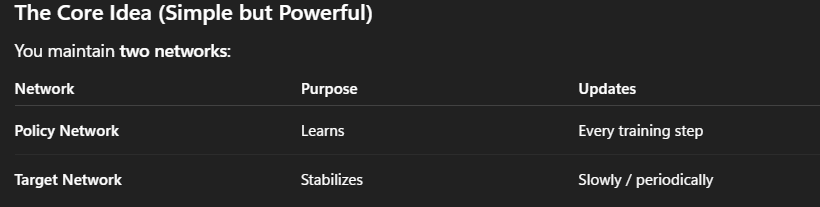

In [14]:
# Creating Target Network
target_net = QNetwork(state_dim, action_dim).to(device)
policy_net = QNetwork(state_dim, action_dim).to(device)

# Initail Synchronization- This insures that the policy and target network in dqn start with same parameters.
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()


QNetwork(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [15]:
# Soft update function
def soft_update(target_net, policy_net, tau):
  for target_param, policy_param in zip(
    target_net.parameters(), policy_net.parameters()
    ):
    target_param.data.copy_(
      tau * policy_param.data + (1.0 - tau) * target_param.data
    )

**Implemention DQN loss function and training step**

In [23]:
gamma = 0.99
batch_size = 64
learning_rate = 1e-3
tau = 0.005

# Optimizer (Policy Network ONLY)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)

#Training Step Function
def train_step(policy_net, target_net, replay_buffer, optimizer, device):
  if len(replay_buffer)< batch_size:
    return None
  # Sample Batch
  states_np, actions_np , rewards_np, next_states_np, dones_np = replay_buffer.sample(batch_size)

  # Convert NumPy arrays to PyTorch tensors with explicit dtypes
  states = torch.tensor(states_np, dtype=torch.float32).to(device)
  actions = torch.tensor(actions_np, dtype=torch.long).unsqueeze(1).to(device)
  rewards = torch.tensor(rewards_np, dtype=torch.float32).unsqueeze(1).to(device)
  next_states = torch.tensor(next_states_np, dtype=torch.float32).to(device)
  dones = torch.tensor(dones_np, dtype=torch.float32).unsqueeze(1).to(device) # Convert bool to float for multiplication

  # Computing Current Q(s,a)
  q_values = policy_net(states)
  q_sa = q_values.gather(1, actions)

  # Computing Target Q values
  with torch.no_grad():
    next_q_values = target_net(next_states)
    max_next_q = next_q_values.max(dim=1, keepdim=True)[0]
    target = rewards + gamma * (1 - dones) * max_next_q

  # Computing Loss
  loss = F.mse_loss(q_sa, target)

  # Backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  soft_update(target_net, policy_net, tau)

  return loss.item()

**Implementing Full Training Loops**

In [18]:
num_episodes = 800
max_steps = 1000

epsilon = 1.0
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995

buffer_capacity = 100_000
batch_size = 64
gamma = 0.99

import numpy as np
from collections import deque
replay_buffer= replayBuffer(buffer_capacity)
policy_net=QNetwork(state_dim=8, action_dim=4).to(device)
target_net=QNetwork(state_dim=8, action_dim=4).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer= torch.optim.Adam(policy_net.parameters(), lr=0.001)

#Logging: These lists track training progress for visualization to monitor if DQN is learning.
episode_rewards=[]
losses=[]



In [24]:
# The training loop
for episodes in range(num_episodes):
  state,_=env.reset()
  total_reward=0

  for step in range(max_steps):
    #1)selecting action
    action= select_action(state, policy_net, epsilon, 4, device)
    #2) Take step in environment
    next_states, reward, terminated, truncated, _= env.step(action)
    done=terminated or truncated

    #3)Storing Transitions
    replay_buffer.push(state, action, reward, next_states, done)
    state=next_states
    total_reward+=reward

    #4)Training Step
    loss= train_step(policy_net,
                     target_net,
                     replay_buffer,
                     optimizer,
                     device)
    if loss is not None:
      losses.append(loss)
    if done:
      break

  #5)Decaying epsion per episode intentionally
  epsilon= max(epsilon_end, epsilon*epsilon_decay)
  episode_rewards.append(total_reward)

  #6)Logging
  if episodes%10==0:
    avg_reward= np.mean(episode_rewards[-10:])
    print(
            f"Episode {episodes:4d} | "
            f"Reward: {total_reward:7.2f} | "
            f"Avg(10): {avg_reward:7.2f} | "
            f"Epsilon: {epsilon:.3f}"
        )







Episode    0 | Reward: -109.27 | Avg(10): -109.27 | Epsilon: 0.995
Episode   10 | Reward: -302.66 | Avg(10): -202.01 | Epsilon: 0.946
Episode   20 | Reward:  -71.26 | Avg(10): -178.91 | Epsilon: 0.900
Episode   30 | Reward: -184.90 | Avg(10): -121.24 | Epsilon: 0.856
Episode   40 | Reward: -208.95 | Avg(10):  -93.44 | Epsilon: 0.814
Episode   50 | Reward: -127.39 | Avg(10):  -95.02 | Epsilon: 0.774
Episode   60 | Reward:  -37.73 | Avg(10): -126.09 | Epsilon: 0.737
Episode   70 | Reward:  -59.78 | Avg(10):  -61.47 | Epsilon: 0.701
Episode   80 | Reward:  -39.16 | Avg(10):  -81.68 | Epsilon: 0.666
Episode   90 | Reward:  -56.54 | Avg(10):  -77.97 | Epsilon: 0.634
Episode  100 | Reward:  -68.84 | Avg(10):  -46.51 | Epsilon: 0.603
Episode  110 | Reward:   10.40 | Avg(10):  -61.23 | Epsilon: 0.573
Episode  120 | Reward:  -29.46 | Avg(10):  -35.93 | Epsilon: 0.545
Episode  130 | Reward: -140.19 | Avg(10):  -51.74 | Epsilon: 0.519
Episode  140 | Reward:   -5.18 | Avg(10):  -71.11 | Epsilon: 0

**Evaluation Loop**

In [25]:
#Switching Policy Network to Evaluation Mode
policy_net.eval()
#Greedy Action Selection(ε=0)
def select_greedy_action(state, policy_net, device):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = policy_net(state)
    return torch.argmax(q_values, dim=1).item()
#Evaluation Loop
def evaluate_agent(env, policy_net, device, episodes=10):
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        while True:
            action = select_greedy_action(state, policy_net, device)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            if terminated or truncated:
                break
        rewards.append(total_reward)
        print(f"Eval Episode {ep+1}: Reward = {total_reward:.2f}")
    avg_reward = sum(rewards) / len(rewards)
    print(f"\nAverage Evaluation Reward: {avg_reward:.2f}")

    return rewards


In [26]:
eval_env = gym.make("LunarLander-v3")
evaluate_agent(eval_env, policy_net, device, episodes=10)
eval_env.close()


Eval Episode 1: Reward = 264.69
Eval Episode 2: Reward = 128.62
Eval Episode 3: Reward = 292.78
Eval Episode 4: Reward = 278.69
Eval Episode 5: Reward = 269.03
Eval Episode 6: Reward = 297.14
Eval Episode 7: Reward = 274.82
Eval Episode 8: Reward = 294.10
Eval Episode 9: Reward = 272.36
Eval Episode 10: Reward = 266.25

Average Evaluation Reward: 263.85


Creating Video-Recording Environment

In [27]:
from gymnasium.wrappers import RecordVideo
video_env = gym.make(
    "LunarLander-v3",
    render_mode="rgb_array"
)

video_env = RecordVideo(
    video_env,
    video_folder="videos",
    episode_trigger=lambda episode_id: True
)


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Running one clean evaluation episode (recorded)

In [28]:
state, _ = video_env.reset()
total_reward = 0

while True:
    action = select_greedy_action(state, policy_net, device)
    state, reward, terminated, truncated, _ = video_env.step(action)
    total_reward += reward

    if terminated or truncated:
        break

video_env.close()
print("Recorded episode reward:", total_reward)

Recorded episode reward: 275.4878154729439


In [29]:
#Downloading Video
import os
os.listdir("videos")

['rl-video-episode-0.mp4']